# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import notMNIST_gen
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# Load Sythetic Dataset
save = notMNIST_gen.gen_composite()
train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

labels = train_labels
new_labels = labels.view('S1').reshape((labels.size, -1))
print(new_labels[0])

Starting
Download Complete
Extract Complete
Saving Complete
Data Dictionaries Built
Training set (200000, 64, 64) (200000,)
Validation set (10000, 64, 64) (10000,)
Test set (10000, 64, 64) (10000,)
[b'A' b'B' b'E' b'H' b' ']


In [3]:
image_size = 64
num_digits = 5
char_labels = [b'A',b'B',b'C',b'D',b'E',b'F',b'G',b'H',b'I',b'J',b' ']
num_labels = len(char_labels)
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = labels.view('S1').reshape((labels.size, -1))
  new_labels = np.ndarray(labels.shape, dtype=np.float32)
  for i in range(new_labels.shape[0]):
    for j in range(new_labels.shape[1]):
        if labels[i,j] in char_labels:
            new_labels[i,j] = char_labels.index(labels[i,j])
  labels = (np.arange(num_labels) == new_labels[:,:,None])
  labels = labels.astype(np.float32)
  return dataset, labels
original_train_labels = train_labels.copy()
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 64, 64, 1) (200000, 5, 11)
Validation set (10000, 64, 64, 1) (10000, 5, 11)
Test set (10000, 64, 64, 1) (10000, 5, 11)


In [4]:
def accuracy(predictions, labels):
    correct_digits = (np.argmax(predictions, 2) == np.argmax(labels, 2))
    correct_addrs = np.all(correct_digits, 1)
    return (100.0 * np.sum(correct_addrs) / predictions.shape[0])

In [19]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
  with tf.name_scope('input_variables'):
      tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels), 
          name='train_dataset_in')
        
      tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_digits, num_labels), name='train_labels_in')
    
      tf_prediction_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels),
          name='prediction_dataset_in')
        
      tf_keep_prob = tf.constant(0.8, name='keep_probability')

  def cnn_var_dict():
      var_dict = {}
      with tf.name_scope('convolutional_net_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, num_channels, depth], stddev=0.1), 
                                                  name='cnn_layer_1_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.zeros([depth]), 
                                                  name='cnn_layer_1__biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, depth, depth], stddev=0.1), 
                                                  name='cnn_layer_2_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[depth]), 
                                                  name='cnn_layer_2_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  def variable_dict(digit):
      var_dict = {}
      with tf.name_scope('Digit_' + digit + '_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [image_size // 4 * image_size // 4 * depth, num_hidden*3], stddev=0.1), 
                                                   name='layer_1_'+ digit + '_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*3]), 
                                                  name='layer_1_'+ digit + '_biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*3, num_hidden*2], stddev=0.1), 
                                                   name='layer_2_'+ digit + '_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*2]), 
                                                  name='layer_2_'+ digit + '_biases')
          var_dict['layer_3_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*2, num_hidden], stddev=0.1), 
                                                   name='layer_3_'+ digit + '_weights')
          var_dict['layer_3_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden]), 
                                                  name='layer_3_'+ digit + '_biases')
          var_dict['layer_4_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1), name='layer_4_'+ digit + '_weights')
          var_dict['layer_4_biases'] = tf.Variable(tf.constant(1.0, shape=[num_labels]), 
                                                  name='layer_4_'+ digit + '_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  cnn_vars = cnn_var_dict()
  deep_vars = {}
  for i in range(num_digits):
        deep_vars[str(i)] = variable_dict(str(i))
                      
  # Model.
  def cnn_model(data, var_set):
    with tf.name_scope('convolutional_net_operations'):
        conv_1 = tf.nn.conv2d(data, var_set['layer_1_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_1')
        conv_1 = tf.nn.max_pool(conv_1, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_1')
        conv_1 = tf.nn.relu(conv_1 + var_set['layer_1_biases'], name='CNN_Relu_1')
        conv_2 = tf.nn.conv2d(conv_1, var_set['layer_2_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_2')
        conv_2 = tf.nn.max_pool(conv_2, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_2')
        conv_2 = tf.nn.relu(conv_2 + var_set['layer_2_biases'], name='CNN_Relu_2')
        shape = conv_2.get_shape().as_list()
        reshape = tf.reshape(conv_2, [shape[0], shape[1] * shape[2] * shape[3]], name='Collapse_to_2d')
    return reshape

  def digit_model(data, digit, keep_prob=1):
      with tf.name_scope('Digit_' + digit + '_operations'):
        hidden_1 = tf.nn.relu(tf.matmul(data, deep_vars[digit]['layer_1_weights']) + 
                              deep_vars[digit]['layer_1_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_1')
        drop_1 = tf.nn.dropout(hidden_1, keep_prob)
        hidden_2 = tf.nn.relu(tf.matmul(drop_1, deep_vars[digit]['layer_2_weights']) + 
                              deep_vars[digit]['layer_2_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_2')
        drop_2 = tf.nn.dropout(hidden_2, keep_prob)
        hidden_3 = tf.nn.relu(tf.matmul(drop_2, deep_vars[digit]['layer_3_weights']) + 
                              deep_vars[digit]['layer_3_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_3')
        drop_3 = tf.nn.dropout(hidden_3, keep_prob)
        result = tf.matmul(drop_3, deep_vars[digit]['layer_4_weights']) + \
                            deep_vars[digit]['layer_4_biases']
      return result

  def base_model(data, keep_prob=1):
      with tf.name_scope('base_model'):
          cnn = cnn_model(data, cnn_vars)
          logit_stack = list()
          for i in range(num_digits):
              logit_stack.append(digit_model(cnn, str(i), keep_prob))
      return tf.stack(logit_stack, axis=1)

  def train_model(logits, labels):
      with tf.name_scope('train_model'):
        softmax_stack = list()
        pred = list()
        for i in range(num_digits):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits[:,i,:], labels[:,i,:])
            softmax_stack.append(tf.reduce_mean(cross_entropy))
        loss = tf.reduce_mean(tf.stack(softmax_stack), name='loss_function')
      return loss

  def make_prediction(logits):
      with tf.name_scope('test_model'):
        pred = list()
        for i in range(num_digits):
              pred.append(tf.nn.softmax(logits[:,i,:]))
        return tf.stack(pred, axis=1)

  def build_loss():
    loss_list = list()
    loss_list.append(tf.nn.l2_loss(cnn_vars['layer_1_weights']))
    loss_list.append(tf.nn.l2_loss(cnn_vars['layer_2_weights']))
    return tf.reduce_mean(loss_list)

  # Training computation.
  with tf.name_scope('training_computation'):
      logits = base_model(tf_train_dataset, tf_keep_prob)
      loss = train_model(logits, tf_train_labels) + build_loss()

  with tf.name_scope('optimizer_computation'):
      global_step = tf.Variable(0, name='global_step')  # count the number of steps taken.
      learning_rate = tf.train.exponential_decay(0.001, global_step, 250, 0.99, name='learning_rate')
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, 
                                                                 name='optimizer')
  
  # Predictions for the validation, and test data.
  with tf.name_scope('predictions'):
      train_prediction = make_prediction(logits)
      batch_predictor = make_prediction(base_model(tf_prediction_dataset))

In [22]:
def batch_prediction(dataset, labels):
  index = 0
  test_accs = []
  while index < dataset.shape[0]:
    batch_data = dataset[index:index+batch_size, :, :, :]
    batch_labels = labels[index:index+batch_size]
    feed_dict = {tf_prediction_dataset : batch_data}
    batch_pred = batch_predictor.eval(feed_dict=feed_dict)
    test_accs.append(accuracy(batch_pred, batch_labels))
    index += batch_size
  return np.mean(test_accs)

In [23]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  writer = tf.summary.FileWriter('logs/nn_logs', graph=graph)
  merged = tf.summary.merge_all()
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :, :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, summary, l, predictions, learn = session.run(
      [optimizer, merged, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    writer.add_summary(summary, step)
    if (step % 2000 == 0):
      print('Minibatch loss at step %d: %f; Learing Rate: %f' % (step, l, learn), end='\t')
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels), end='\t')
      print('Validation accuracy: %.1f%%' % batch_prediction(valid_dataset, valid_labels))
  print('Test accuracy: %.1f%%' % batch_prediction(test_dataset, test_labels))

Initialized
Minibatch loss at step 0: 253.096756; Learing Rate: 0.001000	Minibatch accuracy: 0.0%	Validation accuracy: 2.6%
Minibatch loss at step 2000: 1.292020; Learing Rate: 0.000923	Minibatch accuracy: 18.8%	Validation accuracy: 34.9%
Minibatch loss at step 4000: 0.773677; Learing Rate: 0.000851	Minibatch accuracy: 37.5%	Validation accuracy: 39.1%
Minibatch loss at step 6000: 0.809899; Learing Rate: 0.000786	Minibatch accuracy: 37.5%	Validation accuracy: 45.1%
Minibatch loss at step 8000: 0.627109; Learing Rate: 0.000725	Minibatch accuracy: 37.5%	Validation accuracy: 48.5%
Minibatch loss at step 10000: 0.544494; Learing Rate: 0.000669	Minibatch accuracy: 43.8%	Validation accuracy: 50.6%
Minibatch loss at step 12000: 0.690687; Learing Rate: 0.000617	Minibatch accuracy: 37.5%	Validation accuracy: 52.1%
Minibatch loss at step 14000: 0.419515; Learing Rate: 0.000570	Minibatch accuracy: 75.0%	Validation accuracy: 54.1%
Minibatch loss at step 16000: 0.690441; Learing Rate: 0.000526	Minib

### Question 1
_What approach did you take in coming up with a solution to this problem?_

My first approach to the classification portion of this network was to attempt to explicitly isolate each character using OpenCV, then pass the isolated characters to a single digit classifier I have already trained on the notMNIST dataset. Unfortunately, I was unable reach a level of accuracy with this method that I found acceptable.  

After further study on the logistics of this approach, I concluded that a deep network should be capable of isolating the characters implicitly. I decided to base this approach on the previously mentioned notMNIST character classifier I had on-hand. This classifier uses a 2d convolution, max_pool and relu sequence to process the input image. This sequence is repeated twice before the data is passed through a pair of matrix multiplications separated by a reul activation.  

As this approach achieves a test accuracy of 92.4% on notMNIST, I felt it would likely perform well on the SVHN data, both being difficult computer vision problems.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

My final network consists of a single convolutional network passing data to 5 separate fully connected networks, one for each possible digit. The final prediction is created by stacking the results from the individual digit softmax activations.

The convolutional network consists of 7 operations. The initial dataset is passed through a convolutional layer with 5x5 patches and stride size of 2. It is then passed through a 4x4 max pooling operation and finally through a relu activation. These three layers are repeated before the data is reshaped into a rank 2 tensor for output to the deep networks. With a batch size of 16, the convolutional network output tensor is 16x4096.

Each of the 5 fully connected deep networks have unique weights and biases, sharing the weights between networks resulted in a 15% reduction in validation accuracy. Within each deep network, the dataset is stepped from down from 4096 nodes in stages. Including dropout, these networks consist of 10 operations. Matrix multiplication is followed by relu activation before an 80% keep probability dropout is applied. This is repeated 3 times, stepping 4096 nodes down to 192, then 128 and 64 nodes respectively. The final matrix multiplication results in a 16x11 tensor, which is then passed to a softmax activation to predict the digit.  

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

The model was trained using batches of 16 images, with the softmax layers is executed as softmax cross entropy with logits. The output from those cross entropy operations are stacked together and passed as a single tensor to a reduce mean operation as the loss function. I chose to use the AdamOptimizer, with an exponential decay learning rate. I found that learning rate of 0.001, decay steps of 200 and decay rate 0.99 resulted in validation accuracy rates I could accept. Training lasted for 100,000 epochs.

The synthetic dataset was created by generating a square numpy array and placing letters into the array, using random placement with constraints. The constraints assumed all characters should be below and to the right of previous characters. Once the characters for a sample had been placed, the sample was then resized to the 64x64 image I chose to use. This size was large enough to maintain individual character details, while small enough not to overwhelm the hardware I have available.

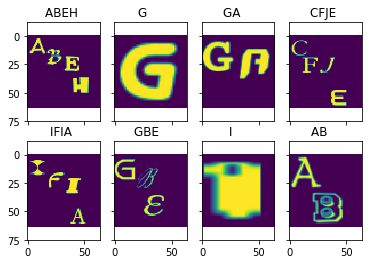

In [13]:
subplt_w = 2
subplt_h = 4
f, axarr = plt.subplots(subplt_w, subplt_h, sharex=True, sharey=True)
count = 0
for i in range(subplt_w):
    for j in range(subplt_h):
        axarr[i, j].imshow(train_dataset[count,:,:,0])
        axarr[i, j].set_title(original_train_labels[count].decode('utf-8'))
        count += subplt_w + subplt_h
plt.show()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [41]:
# Load Sythetic Dataset
import prep_svhn
save = prep_svhn.get_dataset()
train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Starting
Download Complete
Extract Complete
Loading Complete
Combine Train and Extra
Labels Extracted
Dataset Built
Training set (203753, 64, 64) (203753, 5)
Validation set (32000, 64, 64) (32000, 5)
Test set (13068, 64, 64) (13068, 5)


In [42]:
print(train_labels[0])

[b'3' b'7' b' ' b' ' b' ']


In [43]:
image_size = 64
num_digits = 5
char_labels = [b'0', b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9', b' ']
num_labels = len(char_labels)
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  new_labels = np.ndarray(labels.shape, dtype=np.float32)
  for i in range(new_labels.shape[0]):
    for j in range(new_labels.shape[1]):
        if labels[i,j] in char_labels:
            new_labels[i,j] = char_labels.index(labels[i,j])
  labels = (np.arange(num_labels) == new_labels[:,:,None])
  labels = labels.astype(np.float32)
  return dataset, labels
original_train_labels = train_labels.copy()
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (203753, 64, 64, 1) (203753, 5, 11)
Validation set (32000, 64, 64, 1) (32000, 5, 11)
Test set (13068, 64, 64, 1) (13068, 5, 11)


In [44]:
def accuracy(predictions, labels):
    correct_digits = (np.argmax(predictions, 2) == np.argmax(labels, 2))
    correct_addrs = np.all(correct_digits, 1)
    return (100.0 * np.sum(correct_addrs) / predictions.shape[0])

In [48]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 128

graph = tf.Graph()

with graph.as_default():
  with tf.name_scope('input_variables'):
      tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels), 
          name='train_dataset_in')
        
      tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_digits, num_labels), name='train_labels_in')
    
      tf_prediction_dataset = tf.placeholder(
        tf.float32, shape=(1, image_size, image_size, num_channels),
          name='prediction_dataset_in')
        
      tf_keep_prob = tf.constant(0.8, name='keep_probability')

  def cnn_var_dict():
      var_dict = {}
      with tf.name_scope('convolutional_net_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, num_channels, depth], stddev=0.1), 
                                                  name='cnn_layer_1_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.zeros([depth]), 
                                                  name='cnn_layer_1__biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, depth, depth], stddev=0.1), 
                                                  name='cnn_layer_2_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[depth]), 
                                                  name='cnn_layer_2_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  def variable_dict(digit):
      var_dict = {}
      with tf.name_scope('Digit_' + digit + '_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [image_size // 4 * image_size // 4 * depth, num_hidden*3], stddev=0.1), 
                                                   name='layer_1_'+ digit + '_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*3]), 
                                                  name='layer_1_'+ digit + '_biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*3, num_hidden*2], stddev=0.1), 
                                                   name='layer_2_'+ digit + '_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*2]), 
                                                  name='layer_2_'+ digit + '_biases')
          var_dict['layer_3_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*2, num_hidden], stddev=0.1), 
                                                   name='layer_3_'+ digit + '_weights')
          var_dict['layer_3_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden]), 
                                                  name='layer_3_'+ digit + '_biases')
          var_dict['layer_4_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1), name='layer_4_'+ digit + '_weights')
          var_dict['layer_4_biases'] = tf.Variable(tf.constant(1.0, shape=[num_labels]), 
                                                  name='layer_4_'+ digit + '_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  cnn_vars = cnn_var_dict()
  deep_vars = {}
  for i in range(num_digits):
        deep_vars[str(i)] = variable_dict(str(i))
                      
  # Model.
  def cnn_model(data, var_set):
    with tf.name_scope('convolutional_net_operations'):
        conv_1 = tf.nn.conv2d(data, var_set['layer_1_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_1')
        conv_1 = tf.nn.max_pool(conv_1, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_1')
        conv_1 = tf.nn.relu(conv_1 + var_set['layer_1_biases'], name='CNN_Relu_1')
        conv_2 = tf.nn.conv2d(conv_1, var_set['layer_2_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_2')
        conv_2 = tf.nn.max_pool(conv_2, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_2')
        conv_2 = tf.nn.relu(conv_2 + var_set['layer_2_biases'], name='CNN_Relu_2')
        shape = conv_2.get_shape().as_list()
        reshape = tf.reshape(conv_2, [shape[0], shape[1] * shape[2] * shape[3]], name='Collapse_to_2d')
    return reshape

  def digit_model(data, digit, keep_prob=1):
      with tf.name_scope('Digit_' + digit + '_operations'):
        hidden_1 = tf.nn.relu(tf.matmul(data, deep_vars[digit]['layer_1_weights']) + 
                              deep_vars[digit]['layer_1_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_1')
        drop_1 = tf.nn.dropout(hidden_1, keep_prob)
        hidden_2 = tf.nn.relu(tf.matmul(drop_1, deep_vars[digit]['layer_2_weights']) + 
                              deep_vars[digit]['layer_2_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_2')
        drop_2 = tf.nn.dropout(hidden_2, keep_prob)
        hidden_3 = tf.nn.relu(tf.matmul(drop_2, deep_vars[digit]['layer_3_weights']) + 
                              deep_vars[digit]['layer_3_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_3')
        drop_3 = tf.nn.dropout(hidden_3, keep_prob)
        result = tf.matmul(drop_3, deep_vars[digit]['layer_4_weights']) + \
                            deep_vars[digit]['layer_4_biases']
      return result

  def base_model(data, keep_prob=1):
      with tf.name_scope('base_model'):
          cnn = cnn_model(data, cnn_vars)
          logit_stack = list()
          for i in range(num_digits):
              logit_stack.append(digit_model(cnn, str(i), keep_prob))
      return tf.stack(logit_stack, axis=1)

  def train_model(logits, labels):
      with tf.name_scope('train_model'):
        softmax_stack = list()
        pred = list()
        for i in range(num_digits):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits[:,i,:], labels[:,i,:])
            softmax_stack.append(tf.reduce_mean(cross_entropy))
        loss = tf.reduce_mean(tf.stack(softmax_stack), name='loss_function')
      return loss

  def make_prediction(logits):
      with tf.name_scope('test_model'):
        pred = list()
        for i in range(num_digits):
              pred.append(tf.nn.softmax(logits[:,i,:]))
        return tf.stack(pred, axis=1)

  def build_loss():
    loss_list = list()
    loss_list.append(tf.nn.l2_loss(cnn_vars['layer_1_weights']))
    loss_list.append(tf.nn.l2_loss(cnn_vars['layer_2_weights']))
    return tf.reduce_mean(loss_list)

  # Training computation.
  with tf.name_scope('training_computation'):
      logits = base_model(tf_train_dataset, tf_keep_prob)
      loss = train_model(logits, tf_train_labels) + (build_loss() * 0.001)

  with tf.name_scope('optimizer_computation'):
      global_step = tf.Variable(0, name='global_step')  # count the number of steps taken.
      learning_rate = tf.train.exponential_decay(0.001, global_step, 250, 0.99, name='learning_rate')
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, 
                                                                 name='optimizer')
  
  # Predictions for the validation, and test data.
  with tf.name_scope('predictions'):
      train_prediction = make_prediction(logits)
      batch_predictor = make_prediction(base_model(tf_prediction_dataset))

In [49]:
def batch_prediction(dataset, labels):
  test_accs = []
  for i in range(dataset.shape[0]):
    batch_data = dataset[i:i+1, :, :, :]
    batch_labels = labels[i:i+1]
    feed_dict = {tf_prediction_dataset : batch_data}
    batch_pred = batch_predictor.eval(feed_dict=feed_dict)
    test_accs.append(accuracy(batch_pred, batch_labels))
  return np.mean(test_accs)

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  writer = tf.summary.FileWriter('logs/nn_logs', graph=graph)
  merged = tf.summary.merge_all()
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :, :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, summary, l, predictions, learn = session.run(
      [optimizer, merged, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    writer.add_summary(summary, step)
    if (step % 2000 == 0):
      print('Minibatch loss at step %d: %f; Learing Rate: %f' % (step, l, learn), end='\t')
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels), end='\t')
      print('Validation accuracy: %.1f%%' % batch_prediction(valid_dataset, valid_labels))
      print(np.argmax(predictions[0], 1), np.argmax(train_labels[offset], 1))
  print('Test accuracy: %.1f%%' % batch_prediction(test_dataset, test_labels))

Initialized
Minibatch loss at step 0: 19.293100; Learing Rate: 0.001000	Minibatch accuracy: 0.0%	

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

For this model, I combined the training and extra svhn datasets, then set aside the first 32,000 training records as the validation set. The testing set is  the 13,068 testing images provided as part of the SVHN dataset. The remaining 203,753 images comprise my training set.    
I started by extracting the digiStruct data from the .mat files into numpy arrays. My bounding box and label data extraction rely heavily on the MatLab 7.3+ digistruct reader found here (https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader).  
I then used the bounding boxes provided to establish the outer perimeter containing all of the digits in each image by finding the minimum x and y values and the maximum x + w and y + h values.  I then expanded this encompassing bounding box by 10 pixels in every direction.  
The image was cropped to the expanded bounding box. If the cropped image was smaller than the 64 pixel target, the bounding boxes were adjusted to match the cropping and the image was written into the output array.  If either dimension of the image exceeded 64 pixels, it and the bounding boxes were scaled down to fit.  
My first round of testing the model on realistic data, it showed a surprising improvement over my synthetic dataset. This was a result of a bug in my conversion of the data from notMNIST to SVHN. When mapping characters to numeric representations, the notMNIST letter mapping, converted all of the SVHN numerals to the blank character. Predicting every character as blank was easy for the classifier.  
Once I resolved the character mapping, my validation accuracy stayed below 2%, surprisingly low considering the 72% accuracy it displayed on sythetic data.  After compairing the predictions to the labels, I concluded that it was the weight regularization I had attached to the loss function drowning out the cross entropy loss from the classification. Once I removed this extra loss, validation accuracy grew to 21% in 10,000 epochs and 43% over 100,000 epochs.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

Ater resolving the bugs introduced by swapping datasets, the classifier achieved 43% accuracy. 
Reducing the learning rate from 0.001 to 0.0001 resulted in a 33% validation accuracy.

Accuracy  Learning-Rate  Descent-Rate  Hidden  Batch  Epochs
##%       0.001          200           128     4      100,000
27%       0.001          200           64      16     100,000
43%       0.001          250           64      16     100,000
41%       0.001          250           64      16     100,000
33%       0.0001         2500          64      16     100,000
33%       0.001          2500          64      16     100,000

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

Initially, the classifier dropped from 72% accuracy on the synthetic data to 43% accuracy on the realistic dataset. 

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [ ]:
print(mnist['train_labels'][0], mnist['train_bbox'][0])
fig, ax = plt.subplots(1)
ax.imshow(mnist['train_dataset'][0])
bbox = mnist['train_bbox'][0]
rect = patches.Rectangle((bbox[0,0], bbox[0,1]), bbox[0,2], bbox[0,2], fill=None)
ax.add_patch(rect)
plt.show

In [ ]:
tryImage = np.copy(mnist['train_dataset'][0])
origImage = np.copy(tryImage)

dst = cv2.blur(tryImage, (9,9))
edges = cv2.Canny(tryImage, 100, 200)

plt.imshow(edges), plt.xticks([]), plt.yticks([])
print(mnist['train_labels'][0], mnist['train_dataset'][0].shape)

In [ ]:
def roiGen(image, rowCount=1):
    roiDict = {}
    if not (rowCount > 1):
        roiDict[(rowCount, 0, 0)] = image
        return roiDict
    image_shape = image.shape
    colWidth = image_shape[0] // rowCount
    rowHeight = image_shape[1] // rowCount
    for i in range(rowCount):
        i_start = i * colWidth
        i_stop = i_start + (colWidth - 1)
        for j in range(rowCount):
            j_start = j * rowHeight
            j_stop = j_start + (rowHeight -1)
            roiDict[(rowCount, i, j)] = image[i_start:i_stop, j_start:j_stop]
        roiDict[(rowCount, i, rowCount-1)] = image[i_start:i_stop, (rowCount-1)*rowHeight:]
    roiDict[(rowCount, (rowCount-1), (rowCount-1))] = image[(rowCount-1)*colWidth:, (rowCount-1)*rowHeight:]
    return roiDict

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D

model = Sequential()

model.add(Dense(output_dim=4096, input_dim=4096))
model.add(Activation("relu"))
model.add(Convolution2D(nb_filter=1, nb_row=2, nb_col=2, border_mode='same'))
model.add(AveragePooling2d())
model.add(Activation("relu"))
model.add(Convolution2D(nb_filter=1, nb_row=2, nb_col=2, border_mode='same'))
model.add(AveragePooling2d())
model.add(Activation("relu"))
model.add(Convolution2D(nb_filter=1, nb_row=2, nb_col=2, border_mode='same'))
model.add(AveragePooling2d())
model.add(Activation("relu"))
model.add(Dense(output_dim=55))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
X_train = mnist['train_dataset'].reshape(mnist['train_dataset'].shape[0], -1)
Y_train = mnist['train_labels']

model.fit(X_train, Y_train)

In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
image_height = 64
image_width = 64
num_labels = 11
num_channels = 1 # grayscale

import numpy as np

train_dataset = mnist['train_dataset'].reshape((-1, image_height, image_width, num_channels)).astype(np.int8)
valid_dataset = mnist['valid_dataset'].reshape((-1, image_height, image_width, num_channels)).astype(np.int8)
test_dataset = mnist['test_dataset'].reshape((-1, image_height, image_width, num_channels)).astype(np.int8)

train_labels = mnist['train_labels']
valid_labels = mnist['valid_labels']
test_labels = mnist['test_labels']

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

In [ ]:
import random
def dataBatch(data, labels, batchSize = 16):
    limit = len(labels)
    rChoice = []
    for i in range(batchSize):
        rChoice.append(random.randrange(0, limit, 1))
    batchX = np.take(data, rChoice, axis=0)
    batchX = batchX.reshape(batchX.shape[0], batchX.shape[1]**2)
    batchY = np.take(labels, rChoice, axis=0)
    return batchX, batchY

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [ ]:
x = tf.placeholder(tf.float32, [None, 784], name="data")
y_ = tf.placeholder(tf.float32, [None, 11], name="true_labels")

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [ ]:
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 11])
b_fc2 = bias_variable([11])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
# Classifier Function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

with sess.as_default():
    for i in range(20000):
      batch = dataBatch(train_dataset, train_labels, 50)
      if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
      train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print("test accuracy %g"%accuracy.eval(
            feed_dict={x: test_dataset.reshape(
                    test_dataset.shape[0], test_dataset.shape[1]**2), 
                       y_: test_labels, keep_prob: 1.0}))
